<a href="https://colab.research.google.com/github/rero265/StockPriceLSTM/blob/main/StockPriceLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance numpy pandas scikit-learn tensorflow matplotlib


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.1664
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0076
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0018
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0015
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0015
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0014
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0013
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0012
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0012
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0011
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0012
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0013
Epoch 13/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0011
Epoch 14/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 9.9656e-04
Epoch 15/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0014


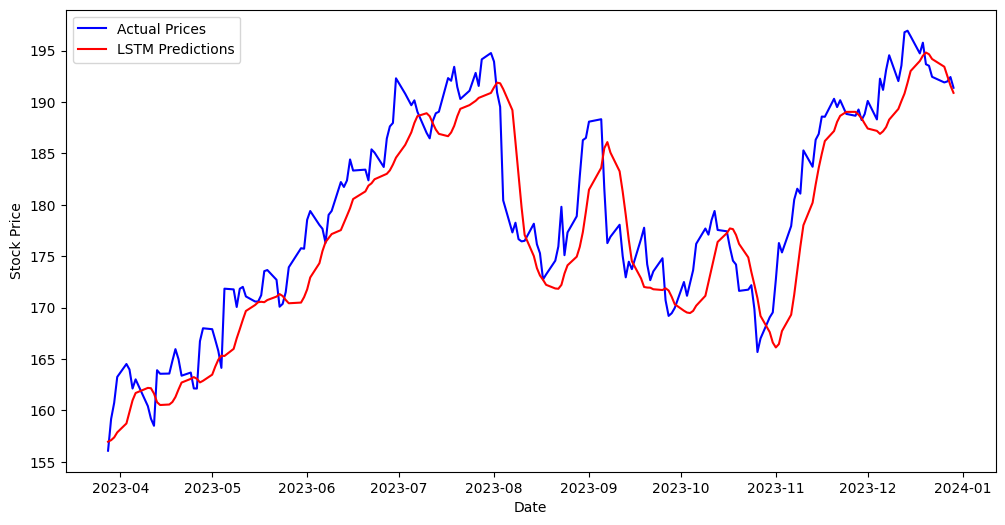

Predicted Next 30 Days Prices: [190.88450276 190.15462888 189.41983793 188.68494508 187.95524954
 187.23535415 186.5289446  185.83954519 185.16907521 184.51937748
 183.89084265 183.28403122 182.69808546 182.1325298  181.58596301
 181.05708575 180.54431846 180.04615799 179.56102476 179.08734769
 178.62376801 178.16882504 177.72144025 177.28015295 176.84427528
 176.412941   175.98491025 175.55974141 175.13681454 174.71601926]


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Fetch Stock Data
def fetch_stock_data(ticker, start="2020-01-01", end="2024-01-01"):
    stock = yf.download(ticker, start=start, end=end)
    return stock[['Close']]  # Using only the 'Close' price

# Step 2: Preprocess Data for LSTM
def prepare_data(stock_data, time_steps=50):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data)

    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:i + time_steps])
        y.append(scaled_data[i + time_steps])

    return np.array(X), np.array(y), scaler

# Step 3: Build LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(50, activation='relu'),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Step 4: Train and Predict
def train_and_predict(ticker):
    # Fetch and prepare data
    stock_data = fetch_stock_data(ticker)
    X, y, scaler = prepare_data(stock_data)

    # Split into training & testing data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build and train model
    model = build_lstm_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # Predict next 30 days
    last_50_days = X_test[-1].reshape(1, 50, 1)
    predictions = []

    for _ in range(30):
        pred = model.predict(last_50_days)[0]
        predictions.append(pred)
        last_50_days = np.append(last_50_days[:, 1:, :], [[pred]], axis=1)

    # Convert predictions back to original scale

    future_prices = scaler.inverse_transform(predictions)

    # Plot Results
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index[-len(y_test):], scaler.inverse_transform(y_test), label="Actual Prices", color='blue')
    plt.plot(stock_data.index[-len(y_test):], scaler.inverse_transform(model.predict(X_test)), label="LSTM Predictions", color='red')
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

    print("Predicted Next 30 Days Prices:", future_prices.flatten())

# Run for a stock (e.g., Apple)
train_and_predict("AAPL")
